In [1]:
import sys
sys.path.append("..")
from flame_analysis_model import *

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import umap
from sklearn.manifold import SpectralEmbedding, TSNE, MDS

import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F

import hdbscan


C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 4GB Laptop GPU


## Read data

In [3]:
df = pd.read_csv("flame_front_po_post0.csv")
print(df.keys())
# Select meaningful physical variables
features = ['v', 'T', 'u', 'dudx', 'dudy', 'dvdx', 'dvdy', 'H2',
       'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2' ]

X = StandardScaler().fit_transform(df[features])
c = X[:, 5]

Index(['x', 'y', 'u', 'v', 'T', 'c', 'dudx', 'dudy', 'dvdx', 'dvdy', 'H2',
       'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2', 'N2', 'omega_H2',
       'omega_O2', 'omega_H2O', 'omega_H', 'omega_O', 'omega_OH', 'omega_HO2',
       'omega_H2O2', 'omega_N2', 'Le_def'],
      dtype='object')


## Autoencoder

In [4]:
num_points, D_orig = X.shape
num_latent = 5
num_hidden = 30

model = AutoEncoder(D_orig, num_latent, num_hidden).to(device)

num_params = sum(p.numel() for p in model.parameters())
print(f"Parameters: {num_params:,} (~{num_params*4/1e6:.2f} MB)")

optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-2
)
criterion = nn.MSELoss()

Parameters: 2,060 (~0.01 MB)


In [5]:
# Dataset & Loader
from torch.utils.data import DataLoader, TensorDataset
X_torch = torch.from_numpy(X).float()
dataset = TensorDataset(X_torch)
loader = DataLoader(dataset, batch_size=1024, shuffle=True)

# Training loop
epochs = 10_000

from torch import amp
torch.backends.cudnn.benchmark = True

scaler = amp.GradScaler("cuda")

for epoch in range(epochs):
    running_loss = 0.0
    for (batch,) in loader:
        batch = batch.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        with amp.autocast("cuda"):                # new API
            decoded, encoded = model(batch)
            loss = criterion(decoded, batch)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * batch.size(0)

    epoch_loss = running_loss / len(dataset)
    if epoch % 500 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.6f}")



Epoch [1/10000] - Loss: 1.011739
Epoch [501/10000] - Loss: 0.013941
Epoch [1001/10000] - Loss: 0.006311
Epoch [1501/10000] - Loss: 0.003665
Epoch [2001/10000] - Loss: 0.002529
Epoch [2501/10000] - Loss: 0.002105
Epoch [3001/10000] - Loss: 0.001842
Epoch [3501/10000] - Loss: 0.001633
Epoch [4001/10000] - Loss: 0.001512
Epoch [4501/10000] - Loss: 0.001406
Epoch [5001/10000] - Loss: 0.001315
Epoch [5501/10000] - Loss: 0.001232
Epoch [6001/10000] - Loss: 0.001175
Epoch [6501/10000] - Loss: 0.001146
Epoch [7001/10000] - Loss: 0.001127
Epoch [7501/10000] - Loss: 0.001066
Epoch [8001/10000] - Loss: 0.001037
Epoch [8501/10000] - Loss: 0.001005
Epoch [9001/10000] - Loss: 0.001004
Epoch [9501/10000] - Loss: 0.000958


In [6]:
X_torch_gpu = X_torch.to(device)
decoded, encoded = model(X_torch_gpu)

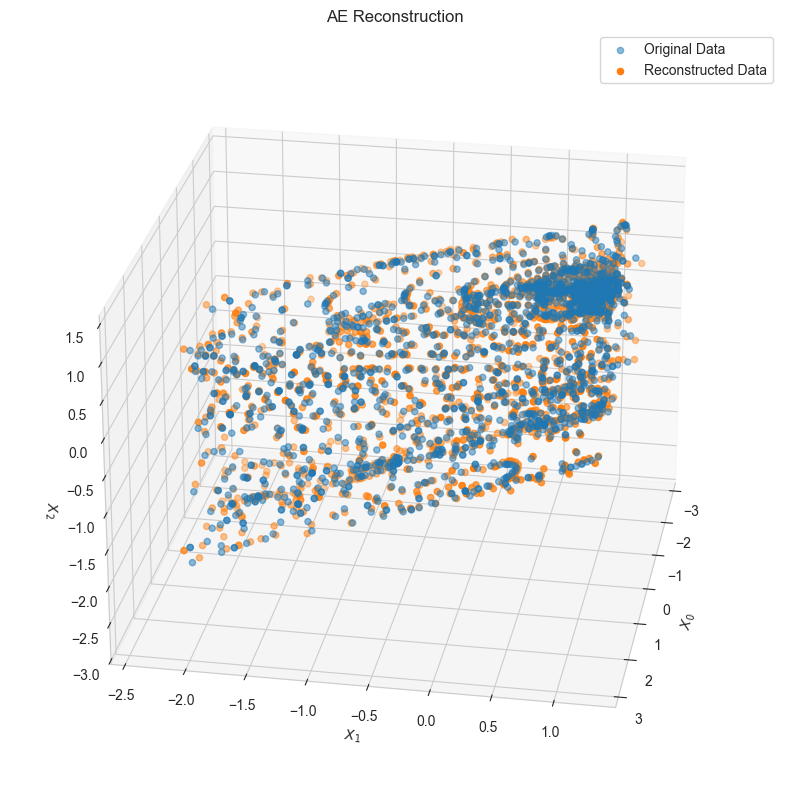

In [7]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
X_P = decoded.detach().cpu().numpy()

ax.scatter(X[:,0], X[:,1], X[:,2],alpha=0.5)
ax.scatter(X_P[:,0], X_P[:,1], X_P[:,2])
ax.set_xlabel('$X_0$')
ax.set_ylabel('$X_1$')
ax.set_zlabel('$X_2$')
ax.elev=25
ax.azim=10
plt.legend(['Original Data','Reconstructed Data'])
plt.title("AE Reconstruction")
plt.show()

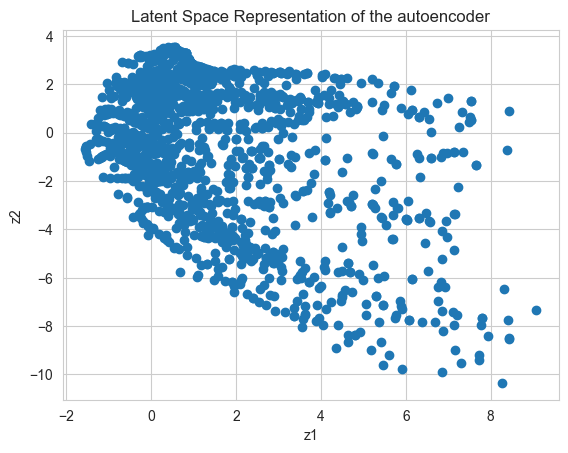

In [8]:
Z = encoded.cpu().detach().numpy()
# Only works if num_latent >=2
if num_latent>=2:
    plt.figure()
    plt.scatter(Z[:,0],Z[:,1])
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('Latent Space Representation of the autoencoder')
    plt.show()

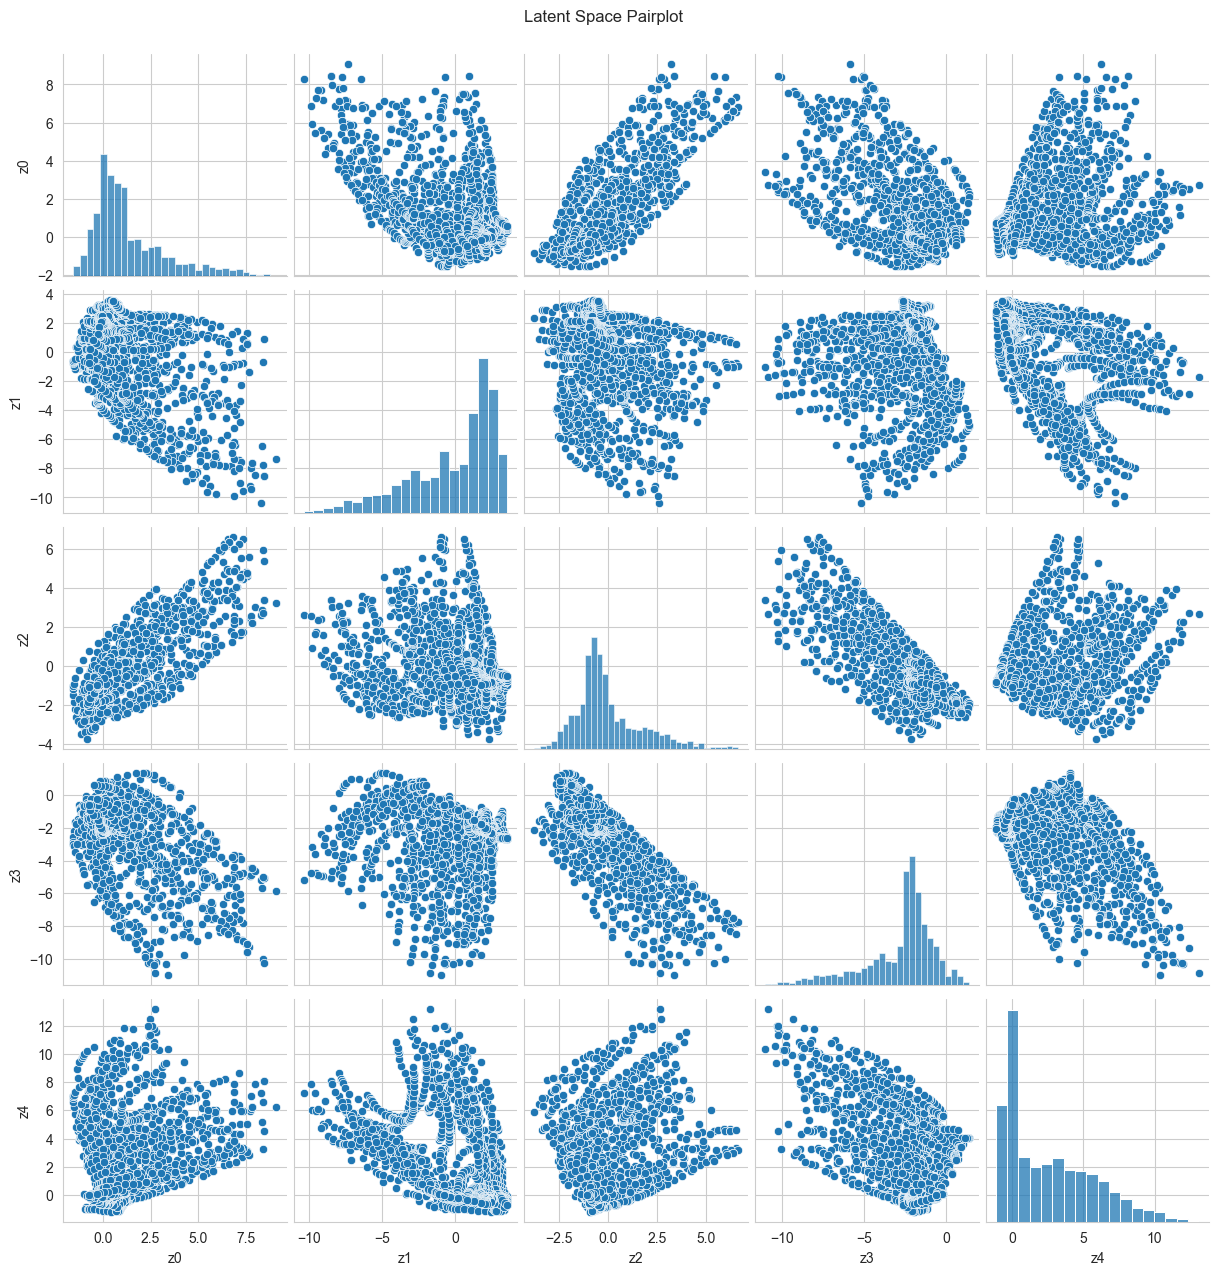

In [9]:
df_latent = pd.DataFrame(Z, columns=[f'z{i}' for i in range(Z.shape[1])])
sns.pairplot(df_latent)
plt.suptitle('Latent Space Pairplot', y=1.02)
plt.show()

## Least Volume Regularization - No Dynamic Pruning(DP)

In [10]:
#| code-fold: false
ambient_dim = X.shape[1]

# Change the below latent dimension to see what happens to the embedded points
latent_dim = 15

width = ambient_dim * 16
encoder = MLP(ambient_dim, latent_dim, [width] * 4)
decoder = MLP(latent_dim, ambient_dim, [width] * 4)

opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4)

#| code-fold: false
# Set X to a torch tensor:
X_torch = torch.from_numpy(X).float()

for i in range(5000):
    opt.zero_grad()
    z = encoder(X_torch)
    rec_loss = F.mse_loss(decoder(z), X_torch)
    loss = rec_loss
    # If you want, you can even add an L1 penalty on the latent space
    # to try to encourage sparsity by uncommenting the line below:
    #loss += 1e-3 * torch.mean(torch.abs(z))

    loss.backward()
    opt.step()
    if (i+1) % 100 == 0:
        print(f'Epoch {i:4}: rec = {rec_loss:.5g}')

Epoch   99: rec = 0.27031
Epoch  199: rec = 0.17144
Epoch  299: rec = 0.030741
Epoch  399: rec = 0.018962
Epoch  499: rec = 0.016111
Epoch  599: rec = 0.013991
Epoch  699: rec = 0.012035
Epoch  799: rec = 0.01087
Epoch  899: rec = 0.010117
Epoch  999: rec = 0.0090033
Epoch 1099: rec = 0.0051576
Epoch 1199: rec = 0.0039702
Epoch 1299: rec = 0.0034781
Epoch 1399: rec = 0.0031697
Epoch 1499: rec = 0.002938
Epoch 1599: rec = 0.0027421
Epoch 1699: rec = 0.0025551
Epoch 1799: rec = 0.0023735
Epoch 1899: rec = 0.0021776
Epoch 1999: rec = 0.0019818
Epoch 2099: rec = 0.0017952
Epoch 2199: rec = 0.001597
Epoch 2299: rec = 0.0013754
Epoch 2399: rec = 0.0010999
Epoch 2499: rec = 0.00090881
Epoch 2599: rec = 0.00072515
Epoch 2699: rec = 0.00060833
Epoch 2799: rec = 0.00050566
Epoch 2899: rec = 0.0004186
Epoch 2999: rec = 0.00037122
Epoch 3099: rec = 0.00033606
Epoch 3199: rec = 0.00032882
Epoch 3299: rec = 0.00031136
Epoch 3399: rec = 0.00025691
Epoch 3499: rec = 0.00024541
Epoch 3599: rec = 0.0002

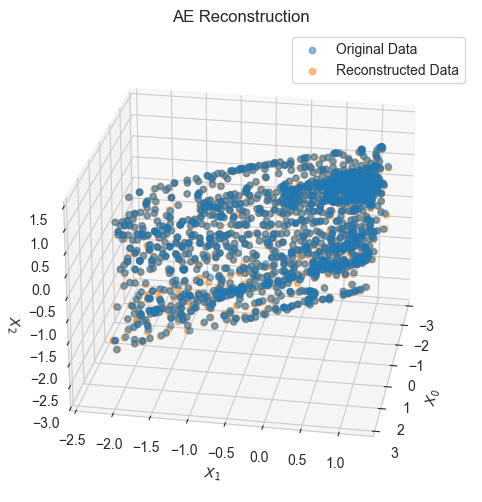

In [11]:
encoder.eval()
decoder.eval()

# Embed the data into Z using the trained encoder
with torch.no_grad():
    z = encoder(X_torch)
    X_P = decoder(encoder(X_torch)).detach().numpy()
# Now let's sort the latent codes by which ones have the
# largest standard deviation in Z:

import matplotlib.pyplot as plt


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], alpha=0.5, label='Original Data')
ax.scatter(X_P[:, 0], X_P[:, 1], X_P[:, 2], alpha=0.5, label='Reconstructed Data')

ax.set_xlabel('$X_0$')
ax.set_ylabel('$X_1$')
ax.set_zlabel('$X_2$')
ax.view_init(elev=25, azim=10)
ax.legend()
plt.title("AE Reconstruction")
plt.show()


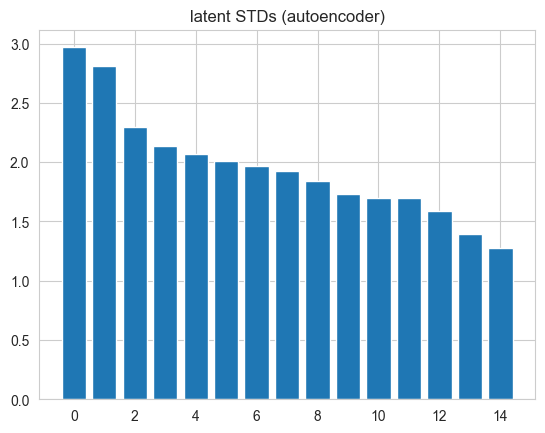

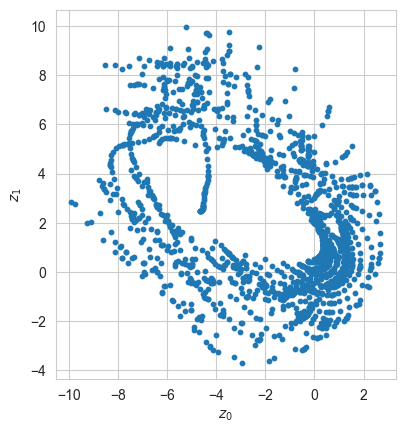

In [12]:
idx = z.std(0).argsort(descending=True)

plt.figure()
plt.bar(np.arange(z.std(0).size(-1)), z.std(0)[idx])
plt.title('latent STDs (autoencoder)')
plt.show()

plt.figure()
plt.scatter(z[:, idx[0]].cpu().detach().numpy(), z[:, idx[1]].cpu().detach().numpy(), s=10)
plt.gca().set_aspect('equal')
plt.xlabel('$z_0$')
plt.ylabel('$z_1$')
plt.show()

## Least Volume - With Dynamic Pruning(DP)

Epoch 1000: rec = 0.0029836, vol = 0.27795
Epoch 2000: rec = 0.0011102, vol = 0.15456
Epoch 3000: rec = 0.00090874, vol = 0.14969
Epoch 4000: rec = 0.00021766, vol = 0.14359
Epoch 5000: rec = 0.00017303, vol = 0.13694
Epoch 6000: rec = 0.00015584, vol = 0.13206
Epoch 7000: rec = 0.00026046, vol = 0.13312
Epoch 8000: rec = 0.00011217, vol = 0.11509
Epoch 9000: rec = 0.0001046, vol = 0.11423
Epoch 10000: rec = 0.0016461, vol = 0.11144
Epoch 11000: rec = 0.001723, vol = 0.084531
Epoch 12000: rec = 8.8119e-05, vol = 0.085757
Epoch 13000: rec = 7.8838e-05, vol = 0.082075
Epoch 14000: rec = 0.00026439, vol = 0.077489
Epoch 15000: rec = 6.7599e-05, vol = 0.08121
Epoch 16000: rec = 0.00032248, vol = 0.076806
Epoch 17000: rec = 5.9775e-05, vol = 0.079628
Epoch 18000: rec = 5.877e-05, vol = 0.077063
Epoch 19000: rec = 0.00011237, vol = 0.073446
Epoch 20000: rec = 0.00011418, vol = 0.07529


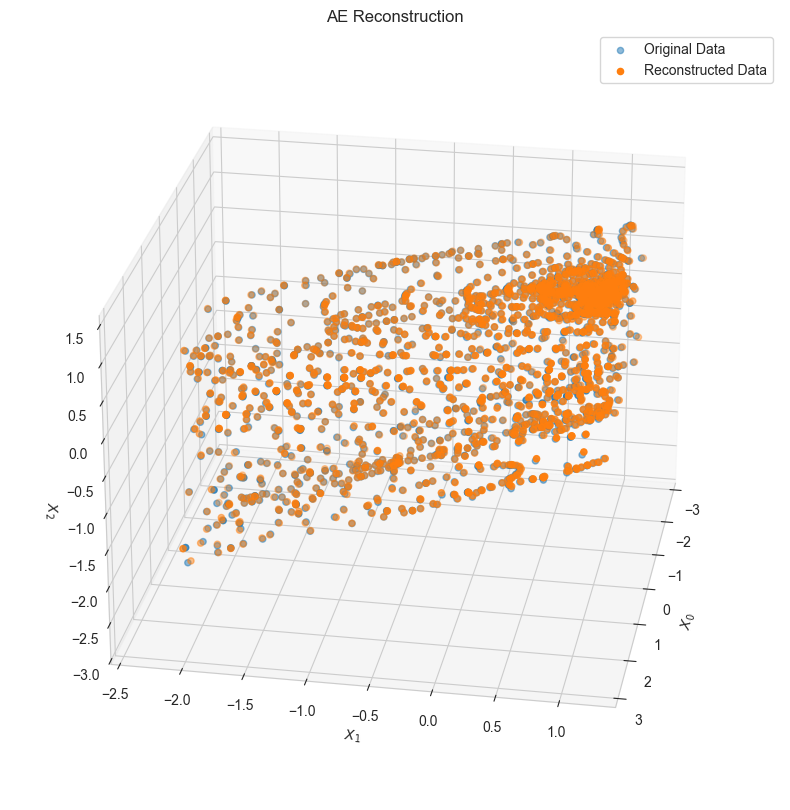

In [13]:


# Move data to GPU
X_torch = X_torch.to(device)
width = ambient_dim * 16
# Define models and move to GPU
encoder = MLP(ambient_dim, ambient_dim, [width] * 4).to(device)
decoder = SNMLP(ambient_dim, ambient_dim, [width] * 4).to(device)

opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

eta, l = 0.01, 0.01

for i in range(20000):
    opt.zero_grad()
    z = encoder(X_torch)
    rec_loss = F.mse_loss(decoder(z), X_torch)
    vol_loss = torch.exp(torch.log(z.std(0) + eta).mean())
    loss = rec_loss + l * vol_loss
    loss.backward()
    opt.step()

    if (i + 1) % 1000 == 0:
        print(f'Epoch {i+1:4}: rec = {rec_loss.item():.5g}, vol = {vol_loss.item():.5g}')

# Move data back to CPU for plotting
encoder.eval()
decoder.eval()
with torch.no_grad():
    X_P = decoder(encoder(X_torch)).cpu().numpy()

X_np = X_torch.cpu().numpy()

# Plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_np[:, 0], X_np[:, 1], X_np[:, 2], alpha=0.5)
ax.scatter(X_P[:, 0], X_P[:, 1], X_P[:, 2])
ax.set_xlabel('$X_0$')
ax.set_ylabel('$X_1$')
ax.set_zlabel('$X_2$')
ax.elev = 25
ax.azim = 10
plt.legend(['Original Data', 'Reconstructed Data'])
plt.title("AE Reconstruction")
plt.show()

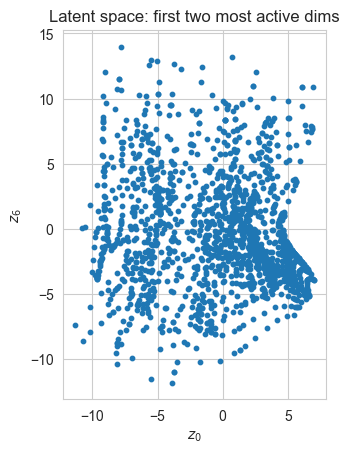

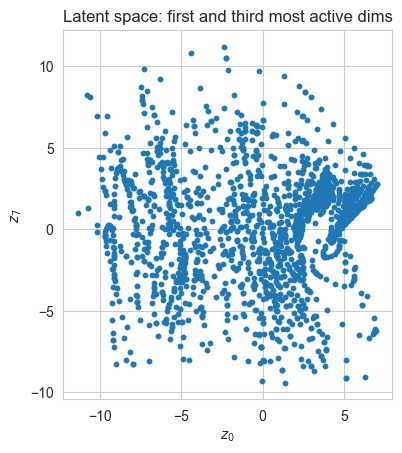

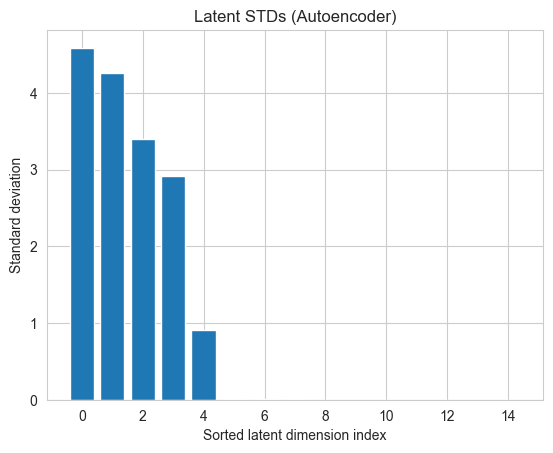

In [14]:
# Switch to eval mode and disable gradient tracking
encoder.eval()
decoder.eval()
with torch.no_grad():
    z = encoder(X_torch)

# Move latent vectors to CPU once and convert to NumPy
z_np = z.detach().cpu().numpy()

# Rank dimensions by standard deviation (importance)
idx = z.std(0).argsort(descending=True)

# ---- Plot 1: z0 vs z1 ----
plt.figure()
plt.scatter(z_np[:, idx[0]], z_np[:, idx[1]], s=10)
plt.gca().set_aspect('equal')
plt.xlabel(f'$z_{{{idx[0]}}}$')
plt.ylabel(f'$z_{{{idx[1]}}}$')
plt.title('Latent space: first two most active dims')
plt.show()

# ---- Plot 2: z0 vs z2 ----
plt.figure()
plt.scatter(z_np[:, idx[0]], z_np[:, idx[2]], s=10)
plt.gca().set_aspect('equal')
plt.xlabel(f'$z_{{{idx[0]}}}$')
plt.ylabel(f'$z_{{{idx[2]}}}$')
plt.title('Latent space: first and third most active dims')
plt.show()

# Compute and sort latent STDs
z_std = z.std(0).detach().cpu().numpy()
idx = z.std(0).detach().cpu().argsort(descending=True)

# Plot
plt.figure()
plt.bar(np.arange(len(z_std)), z_std[idx])
plt.title('Latent STDs (Autoencoder)')
plt.xlabel('Sorted latent dimension index')
plt.ylabel('Standard deviation')
plt.show()




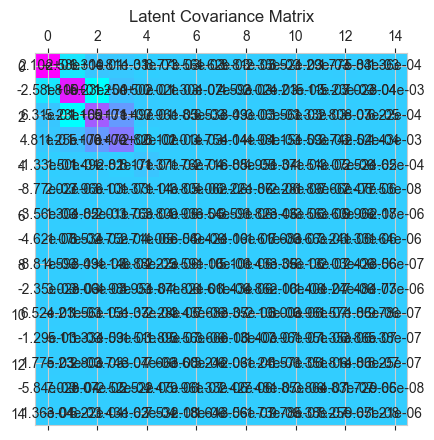

In [15]:
cov = z.T[idx].cov().detach().cpu().numpy()
plt.matshow(cov, cmap='cool')
for (i, j), var in np.ndenumerate(cov):
    plt.gca().text(j, i, '{:.2e}'.format(var), ha='center', va='center')
plt.title('Latent Covariance Matrix')
plt.show()

In [16]:
# df_GLV = pd.DataFrame(z.cpu().detach().numpy(), columns=[f'z{i}' for i in range(z.shape[1])])
# plt.figure()
# sns.pairplot(df)
# plt.suptitle('Latent Space Pairplot', y=1.02)
# plt.show()